# Step-by-step Example

In this example, I'm going to show you how to use RLTK to solve a real problem.

## Problem & Dataset analysis

The data we used here is called Abt-Buy, which can be found [here](https://github.com/usc-isi-i2/rltk-experimentation/tree/master/datasets/Abt-Buy). Abt.com (Abt.csv) and Buy.com (Buy.csv) are two e-commerce retailers, the goal is to find all matches (abt_buy_perfectMapping.csv) of products between these two files.

Let's take a look of these files first. `wc`, `less` and `grep` are great tools to start with, then `pandas` or other data analysis tools / libraries can tell you more detailed information. Here's what I will do:

In [1]:
# initialization
import os
if not os.getcwd().endswith('rltk-experimentation'):
    os.chdir('../../rltk-experimentation')
import pandas as pd
from IPython.display import display

In [2]:
def print_stats(fp):
    print(fp)
    df_data = pd.read_csv(fp, encoding='latin-1')
    
    print('\nfirst 5 rows:')
    display(df_data.head(5))
    
    stat = []
    for i in range(df_data.shape[1]):
        stat.append(df_data.shape[0] - df_data.iloc[:,i].isnull().sum())
    df_stat = pd.DataFrame([stat], columns=df_data.columns.values.tolist())
    df_stat.rename(index={0: 'total'}, inplace=True)
    print('\ntotal number of rows:')
    display(df_stat.head(1))
    print('\n')
    
print_stats('datasets/Abt-Buy/abt.csv')
print_stats('datasets/Abt-Buy/buy.csv')
print_stats('datasets/Abt-Buy/abt_buy_perfectMapping.csv')

datasets/Abt-Buy/abt.csv

first 5 rows:


,id,name,description,price
0,552,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,NaN
1,580,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,$399.00
2,4696,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,$49.00
3,5644,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,NaN
4,6284,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,$158.00



total number of rows:


,id,name,description,price
total,1081,1081,1081,418




datasets/Abt-Buy/buy.csv

first 5 rows:


,id,name,description,manufacturer,price
0,10011646,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,LINKSYS,NaN
1,10140760,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,LINKSYS,NaN
2,10221960,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,Netgear,NaN
3,10246269,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,Belkin,NaN
4,10315184,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,Netgear,NaN



total number of rows:


,id,name,description,manufacturer,price
total,1092,1092,651,1086,590




datasets/Abt-Buy/abt_buy_perfectMapping.csv

first 5 rows:


,idAbt,idBuy
0,38477,10011646
1,38475,10140760
2,33053,10221960
3,27248,10246269
4,25262,10315184



total number of rows:


,idAbt,idBuy
total,1097,1097


After a rough inspection, the summaries are:

- Abt
    - It has 1081 items and all items have `id`, `name` and `description`, only 414 items have `price`.
    - It seems `name` is formed in the pattern `{product name} - {model}`
- Buy
    - It has 1092 items and all items have `id` and `name`, 1086 items have `manufacturer`, some items have description and prices.
    - Some of the `name`s are formed in pattern `{product name} - {model}`, somes are `{product name} - {probably sku id}`
- Most of the `name` have brand / manufacturer included.
- There are 1097 matches in total.

## Construct RLTK components

> One thing you should notice here is that my Record is not built immediately. I usually do a very basic one first, then evaluate the linkage result to find what should be improved. It's like a feedback system, after serveral rounds improvement, you should get a better Record.

My personal assumption is, brand (manufacturer) and model can be two strong indicators: if two records have same brand and same model, there's a very high possibility that they belong to same entity.

So I write couple of functions to do tokenization, model & brand extraction, name alias parsing.

In [3]:
import rltk

tokenizer = rltk.CrfTokenizer()


model_stop_words = set([])
with open('Abt-Buy/rltk_exp/stop_words_model.txt') as f:
    for line in f:
        line = line.strip().lower()
        if line:
            model_stop_words.add(line)


def extract_possible_model(s):
    possible_models = []
    tokens = s.split(' ')

    for t in tokens:
        t = t.replace('(', '').replace(')', '')
        if len(t) < 2 or t in model_stop_words:
            continue

        if t.isdigit():
            possible_models.append(t)
            continue

        has_digit = has_alpha = False
        for c in t:
            if c.isdigit():
                has_digit = True
            elif c.isalpha():
                has_alpha = True
            if has_digit and has_alpha:
                possible_models.append(t)

    possible_models.sort(key=len, reverse=True)

    return possible_models[0] if len(possible_models) > 0 else ''


def tokenize(s):
    tokens = tokenizer.tokenize(s)
    return [w.lower() for w in tokens if w.isalpha()]


def get_brand_name(tokens):
    for word_len in range(min(5, len(tokens)), 0, -1):
        i = 0; j = i + word_len
        while j <= len(tokens):
            name = ' '.join(tokens[i:j])
            if name in brand_list:
                return name
            i += 1; j += 1
    return ''


def process_brand_alias(alias):
    return brand_mapping.get(alias, alias)


brand_list = set([])
with open('Abt-Buy/rltk_exp/brands.txt') as f:
    for line in f:
        line = line.strip().lower()
        if len(line) == 0:
            continue
        brand_list.add(' '.join(tokenize(line)))

brand_mapping = {}
with open('Abt-Buy/rltk_exp/brand_alias.txt') as f:
    for line in f:
        alias = [w.strip().lower() for w in line.split('|')]
        for name in alias:
            brand_mapping[name] = alias[0]

Then, I build Records and Datasets.

In [4]:
class AbtRecord(rltk.Record):
    def __init__(self, raw_object):
        super().__init__(raw_object)
        self.brand = ''

    @rltk.cached_property
    def id(self):
        return self.raw_object['id']

    @rltk.cached_property
    def name(self):
        return self.raw_object['name'].split(' - ')[0]

    @rltk.cached_property
    def name_tokens(self):
        tokens = tokenize(self.name)

        self.brand = get_brand_name(tokens)

        return set(tokens)

    @rltk.cached_property
    def model(self):
        ss = self.raw_object['name'].split(' - ')
        return ss[-1].strip() if len(ss) > 1 else ''

    @rltk.cached_property
    def description(self):
        return self.raw_object.get('description', '')

    @rltk.cached_property
    def price(self):
        p = self.raw_object.get('price', '')
        if p.startswith('$'):
            p = p[1:].replace(',', '')
        return p

    @rltk.cached_property
    def brand_cleaned(self):
        _ = self.name_tokens
        return process_brand_alias(self.brand)

    @rltk.cached_property
    def model_cleaned(self):
        m = self.model
        return m.lower().replace('-', '').replace('/', '').replace('&', '')

In [5]:
class BuyRecord(rltk.Record):
    def __init__(self, raw_object):
        super().__init__(raw_object)
        self.brand = ''

    @rltk.cached_property
    def id(self):
        return self.raw_object['id']

    @rltk.cached_property
    def name(self):
        return self.raw_object['name'].split(' - ')[0]

    @rltk.cached_property
    def name_tokens(self):
        tokens = tokenize(self.name)
        self.brand = get_brand_name(tokens)
        return set(tokens)

    @rltk.cached_property
    def description(self):
        return self.raw_object.get('description', '')

    @rltk.cached_property
    def manufacturer(self):
        return self.raw_object.get('manufacturer', '').lower()

    @rltk.cached_property
    def price(self):
        p = self.raw_object.get('price', '')
        if p.startswith('$'):
            p = p[1:].replace(',', '')
        return p

    @rltk.cached_property
    def model(self):
        ss = self.raw_object['name'].split(' - ')
        ss = ss[0].strip()

        return extract_possible_model(ss)

    @rltk.cached_property
    def name_suffix(self): # could probably be the model
        ss = self.raw_object['name'].split(' - ')
        return BuyRecord._clean(ss[-1]) if len(ss) > 1 else ''

    @staticmethod
    def _clean(s):
        return s.lower().replace('-', '').replace('/', '').replace('&', '')

    @rltk.cached_property
    def brand_cleaned(self):
        _ = self.name_tokens
        manufacturer = self.manufacturer
        return process_brand_alias(manufacturer if manufacturer != '' else self.brand)

    @rltk.cached_property
    def model_cleaned(self):
        m = self.model
        return BuyRecord._clean(m)

In [6]:
ds_abt = rltk.Dataset(reader=rltk.CSVReader(open('datasets/Abt-Buy/Abt.csv', encoding='latin-1')),
                   record_class=AbtRecord, adapter=rltk.MemoryAdapter())

ds_buy = rltk.Dataset(reader=rltk.CSVReader(open('datasets/Abt-Buy/Buy.csv', encoding='latin-1')),
                   record_class=BuyRecord, adapter=rltk.MemoryAdapter())

> Notes:
>
> - `cached_property` is set for pre-computing. It's recommended to use if the property generating is time consuming.
> - If you are using persistent Adapter (Redis, HBase) in Dataset, you can reuse it by calling `rltk.Dataset(adapter=...)` without other parameters.

## Rule based solution

One traditional way of solving record linkage problem is using some rules.

### Build ground truth

Since abt_buy_perfectMapping.csv contains all positives, the combinations of two records should be negative. There are lot of ways to generate negatives and RLTK also provides many methods.

My plan here is to use first 100 perfect matches as positive and generate all negatives based the cross product of all ids appear in these matches.

In [7]:
gt = rltk.GroundTruth()
line_count = 0
with open('datasets/Abt-Buy/abt_buy_perfectMapping.csv', encoding='latin-1') as f:
    for d in rltk.CSVReader(f): # this can be replace to python csv reader
        gt.add_positive(d['idAbt'], d['idBuy'])
gt.generate_all_negatives(ds_abt, ds_buy, range_in_gt=True)

### Generate results

Let's come up with some rules and generate results.

In [8]:
def rule_based_method(r_abt, r_buy):
    brand_score = 0
    if r_abt.brand_cleaned and r_buy.brand_cleaned:
        if r_abt.brand_cleaned == r_buy.brand_cleaned:
            brand_score = 1
    model_score = 0
    if r_abt.model_cleaned and r_buy.model_cleaned:
        if r_abt.model_cleaned == r_buy.model_cleaned:
            model_score = 1
    jaccard_score = rltk.jaccard_index_similarity(r_abt.name_tokens, r_buy.name_tokens)

    if model_score == 1:
        return True, 1

    total = brand_score * 0.3 + model_score * 0.3 + jaccard_score * 0.4
    return total > 0.45, total

Trial can be used to record and evaluate results.

In [9]:
trial = rltk.Trial(gt)
candidate_pairs = rltk.get_record_pairs(ds_abt, ds_buy, ground_truth=gt)
for r_abt, r_buy in candidate_pairs:
    result, confidence = rule_based_method(r_abt, r_buy)
    trial.add_result(r_abt, r_buy, result, confidence)

### Evaluation

In [10]:
trial.evaluate()
print(trial.true_positives, trial.false_positives, trial.true_negatives, trial.false_negatives,
      trial.precision, trial.recall, trial.f_measure)
print('tp:', len(trial.true_positives_list))
print('fp:', len(trial.false_positives_list))
print('tn:', len(trial.true_negatives_list))
print('fn:', len(trial.false_negatives_list))

0.7082953509571559 0.0018527076240826554 0.9981472923759174 0.2917046490428441 0.26232275489534096 0.7082953509571559 0.38285291943828526
tp: 777
fp: 2185
tn: 1177170
fn: 320


Instead of setting a pre-computed `is_positive` mark, theshold can be decided at evaluation time. What's more, if you have a collection of `Trial`s, you can use `rltk.Evaluation` to plot a chart.

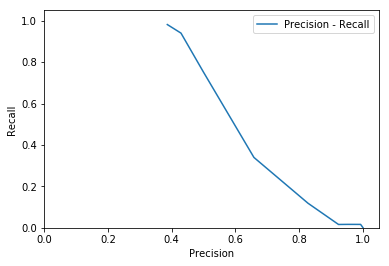

In [11]:
eva = rltk.Evaluation()
for threshold in range(0, 10):
    threshold = float(threshold) / 10
    t = trial.clone() # remember to clone it
    t.evaluate(threshold)
    eva.add_trial(t)
eva.plot_precision_recall().show()

## machine learning solution

coming soon...

### Generate stratified ground truth

coming soon...

### Train test split

coming soon...

### Feature vector

coming soon...

## Blocking

coming soon...

## Perfomance optimization

coming soon...
